In [2]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import xarray as xr
import pandas as pd

import os
import glob
import pickle

from scipy import ndimage
from skimage.segmentation import flood_fill

In [4]:
datapd = pd.read_csv('all_coord.csv')

In [5]:
def ispickleexists(n, p0):
    p = p0 + n + '.pickle'
    if os.path.exists(p):
        # print('    [o] {} exists.'.format(p))
        return True
    else:
        return False

def openpickle(n, p0):
    p = p0 + n + '.pickle'
    with open(p, 'rb') as df:
        d = pickle.load(df)
    return d

def find_first_non_nan_row(da):
    """
    Finds the first row in each column where the value is not NaN.
    Returns:
        An xarray DataArray containing the coordinates of the first non-NaN value in each column.
    """
    # Find non-NaN values
    not_nan = ~da.isnull()
    # Get the indices of the first non-NaN value 
    first_non_nan_indices = not_nan.argmax(da.dims[len(da.dims)-2])
    # Get the corresponding coordinate values
    first_non_nan_rows = da[da.dims[len(da.dims)-2]][first_non_nan_indices]
    return first_non_nan_rows

def detect_polynya(daice, daarea, ice_threshold, area_threshold):
    s = ndimage.generate_binary_structure(2,2)
    da_masked = xr.DataArray(np.nan*np.empty_like(daice), dims = daice.dims, coords = daice.coords)
    for year in daice.time:
        ice0 = daice.sel(time = year)
        icenew = ice0 <= ice_threshold
        ice = xr.where(np.isnan(ice0), True, icenew)   # get rid of "coastal polynya" 
        ice = xr.where(ice0[ice0.dims[len(ice0.dims)-2]] == find_first_non_nan_row(ice0), True, ice) # buffering (one more layer)
        labeled_image, num_features = ndimage.label(ice, structure = s)
        if num_features <= 2:
            continue
        mask = np.zeros_like(labeled_image)
        for i in range(2, num_features+1):
            area = daarea.where(labeled_image == i).sum()/1e6  # m2 -> km2
            if (area > area_threshold[0]) and (area < area_threshold[1]):  # the area of open 'polynya' within the sea ice extent is small
                mask[labeled_image == i] = 1
        da_masked.loc[year] = xr.where(mask, ice0, np.nan)
    return da_masked #.mean('time'), da_masked.count('time')


def savepickle(n, p0, sf):
    p = p0 + n + '.pickle'
    with open(p, 'wb') as wf:
        pickle.dump(sf, wf, pickle.HIGHEST_PROTOCOL)

In [6]:
ice_thresholds = np.arange(0, 100, step=5)
area_threshold = [10000, 1000000]

In [13]:
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    print("{} {}".format(i, name))
    if pd.isna(datapd.at[i, 'xname']):
        print("    [x] doesn't have regular grid.")
        continue
    if ispickleexists(name, 'data_siconc_w_area/'):
        ds = openpickle(name, 'data_siconc_w_area/')
        for ice_threshold in ice_thresholds:
            print("    {} : ".format(ice_threshold), end = '')
            new_name = name + '_'+ str(ice_threshold)
            if ispickleexists(new_name, 'data_polynya/'):
                print("[o] exist.")
                continue
            ice_max = ds.siconc.max('time')
            ice_masked = detect_polynya(ds.siconc, ds.areacello, ice_threshold, area_threshold)
            polynya_count = ice_masked.count('time')
            polynya_freq = polynya_count.where(polynya_count>0) / len(ice_masked.time)

            try:
                new_ds = xr.Dataset(
                    data_vars={
                        'ice_max':ice_max.load(), 
                        'polynya_freq':polynya_freq.load(), 
                        'newlat':ds.newlat.load(),
                        'newlon':ds.newlon.load()
                    }
                )
                savepickle(new_name, 'data_polynya/', new_ds)
                print("[*] complete!")
            except Exception as error:
                print("[!] An exception occurred:", error) # An exception occurred
                


0 BCC-CSM2-MR
    0 : [*] complete!
    5 : [*] complete!
    10 : [*] complete!
    15 : [*] complete!
    20 : [*] complete!
    25 : [*] complete!
    30 : [*] complete!
    35 : [*] complete!
    40 : [*] complete!
    45 : [*] complete!
    50 : [o] exist.
    55 : [o] exist.
    60 : [o] exist.
    65 : [o] exist.
    70 : [o] exist.
    75 : [o] exist.
    80 : [o] exist.
    85 : [o] exist.
    90 : [*] complete!
    95 : [*] complete!
1 BCC-ESM1
    0 : [*] complete!
    5 : [*] complete!
    10 : [*] complete!
    15 : [*] complete!
    20 : [*] complete!
    25 : [*] complete!
    30 : [*] complete!
    35 : [*] complete!
    40 : [*] complete!
    45 : [*] complete!
    50 : [o] exist.
    55 : [o] exist.
    60 : [o] exist.
    65 : [o] exist.
    70 : [o] exist.
    75 : [o] exist.
    80 : [o] exist.
    85 : [o] exist.
    90 : [*] complete!
    95 : [*] complete!
2 CAMS-CSM1-0
    0 : [*] complete!
    5 : [*] complete!
    10 : [*] complete!
    15 : [*] complete!
   

In [12]:
## try set ice_threshold as average siconc
area_threshold = [10000, 1000000]

for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    print("{} {}".format(i, name))
    if pd.isna(datapd.at[i, 'xname']):
        print("    [x] doesn't have regular grid.")
        continue
    if ispickleexists(name, 'data_siconc_w_area/'):
        ds = openpickle(name, 'data_siconc_w_area/')
        ice_threshold = ds.siconc.where(ds.siconc>0).mean().values
        new_name = name + '_mean'
        if ispickleexists(new_name, 'data_polynya/'):
            print("    [o] exist.")
            continue
        ice_max = ds.siconc.max('time')
        ice_masked = detect_polynya(ds.siconc, ds.areacello, ice_threshold, area_threshold)
        polynya_count = ice_masked.count('time')
        polynya_freq = polynya_count.where(polynya_count>0) / len(ice_masked.time)
        new_ds = xr.Dataset(data_vars={
             'ice_max':ice_max.load(), 
             'polynya_freq':polynya_freq.load(), 
             'newlat':ds.newlat.load(),
             'newlon':ds.newlon.load(),
             'threshold':ds.siconc.where(ds.siconc>0).mean()
        })
        savepickle(new_name, 'data_polynya/', new_ds)
        print("    [*] complete!")

0 BCC-CSM2-MR
    [o] exist.
1 BCC-ESM1
    [o] exist.
2 CAMS-CSM1-0
    [o] exist.
3 ACCESS-ESM1-5
    [o] exist.
4 ACCESS-CM2
    [o] exist.
5 GFDL-CM4
    [o] exist.
6 GFDL-ESM4
    [o] exist.
7 KIOST-ESM
    [o] exist.
8 NESM3
    [o] exist.
9 CanESM5
    [o] exist.
10 CanESM5-1
    [o] exist.
11 CanESM5-CanOE
    [o] exist.
12 CMCC-CM2-SR5
    [o] exist.
13 CMCC-ESM2
    [o] exist.
14 EC-Earth3
    [o] exist.
15 EC-Earth3-CC
    [o] exist.
16 EC-Earth3-LR
    [o] exist.
17 EC-Earth3-Veg
    [o] exist.
18 EC-Earth3-Veg-LR
    [o] exist.
19 EC-Earth3-AerChem
    [o] exist.
20 CNRM-CM6-1
    [o] exist.
21 CNRM-CM6-1-HR
    [o] exist.
22 CNRM-ESM2-1
    [o] exist.
23 HadGEM3-GC31-LL
    [o] exist.
24 HadGEM3-GC31-MM
    [o] exist.
25 UKESM1-0-LL
    [o] exist.
26 UKESM1-1-LL
    [o] exist.
27 IPSL-CM5A2-INCA
    [o] exist.
28 IPSL-CM6A-LR
    [o] exist.
29 IPSL-CM6A-MR1
    [o] exist.
30 MIROC6
    [o] exist.
31 MIROC-ES2L
    [o] exist.
32 MIROC-ES2H
    [o] exist.
33 MRI-ESM2-0
    

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import matplotlib.path as mpath
import cmocean
import seaborn as sns

In [8]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [9]:
def plot_multi_map(datapd, ice_threshold, title_threshold=False, figsize = (7, 8)):
    fig = plt.figure(figsize=figsize)
    
    n = 1

    for i in range(0, len(datapd)):
        name = datapd.at[i, 'source_id']
        dataname = name + '_'+ str(ice_threshold)
        if not ispickleexists(dataname, 'data_polynya/'):
            continue
        ds = openpickle(dataname, 'data_polynya/')
        ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(
            left=0.01,
            bottom=0.01,
            right=0.99,
            top=0.99,
            wspace=0.04,
            hspace=0.04
        )
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        if title_threshold:
            if ice_threshold == 'mean':
                title = str(round(ds.threshold.values.item())) + '%'
            else:
                title = str(ice_threshold) + '%'
            ax.text(0,-90, title, fontsize=6)
        ax.set_title(name, fontsize=6, pad=-0.5)
        pltx = ds.newlon
        plty = ds.newlat
        ice_max = ds.ice_max
        polynya_freq = ds.polynya_freq


        im = ax.pcolormesh(pltx, plty, ice_max, 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=100, 
                           cmap=cmocean.cm.ice)
        
        im2 = ax.pcolormesh(pltx, plty, polynya_freq, 
                            transform=ccrs.PlateCarree(), 
                            vmin = 0, vmax = 0.20, cmap=plt.cm.Spectral)
        ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1       
        
    cbar_ax1 = fig.add_axes([0.65, 0.11, 0.30, 0.01])
    cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
    cbar1.ax.tick_params(labelsize=6,direction='in') 
    
    cbar_ax2 = fig.add_axes([0.65, 0.06, 0.30, 0.01])
    cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')
    cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
    cbar2.ax.tick_params(labelsize=6,direction='in')
    savename = 'Polynya_Multi' + '_' + str(ice_threshold) + '.png'
    fig.savefig(savename, dpi = 300)


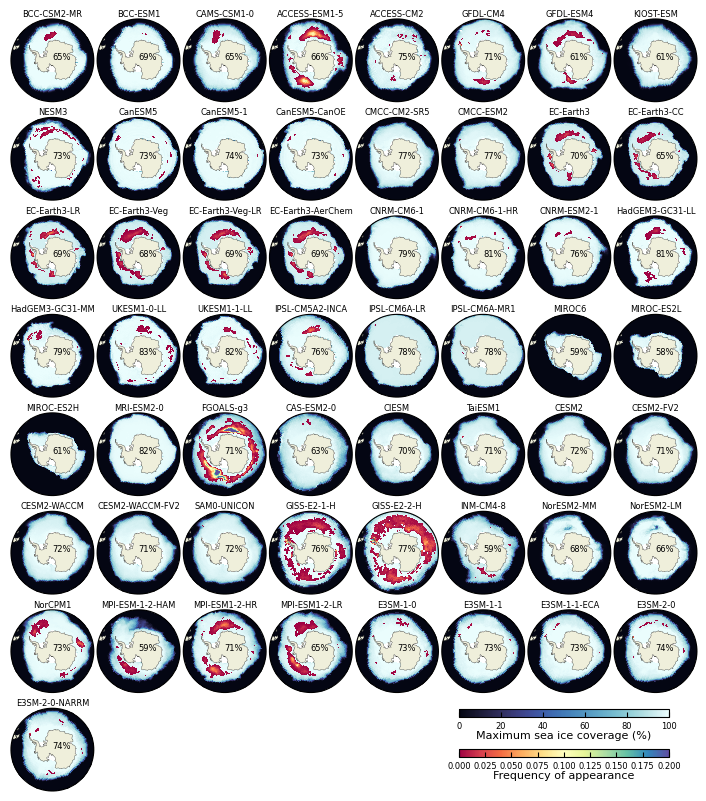

In [13]:
plot_multi_map(datapd, 'mean', title_threshold=True)

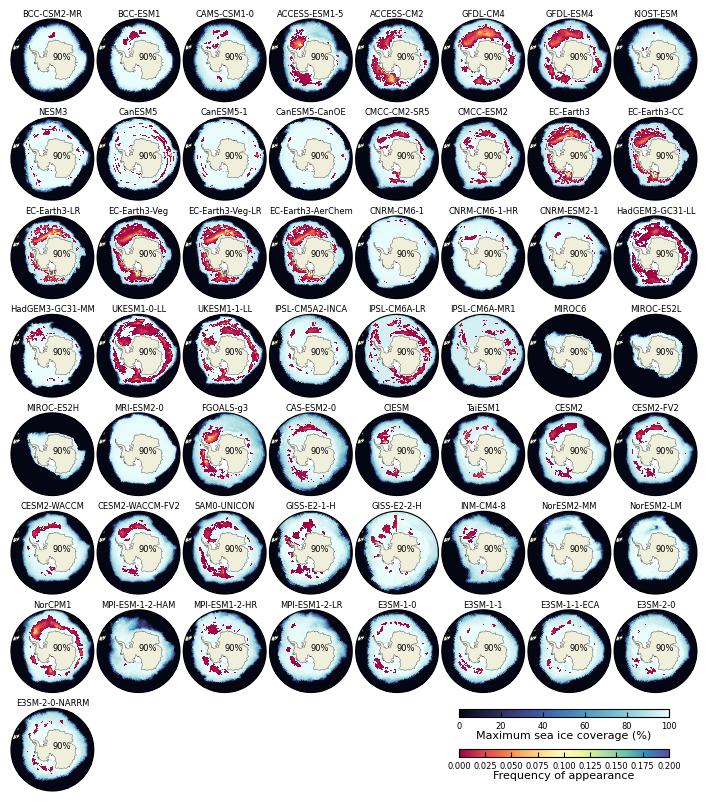

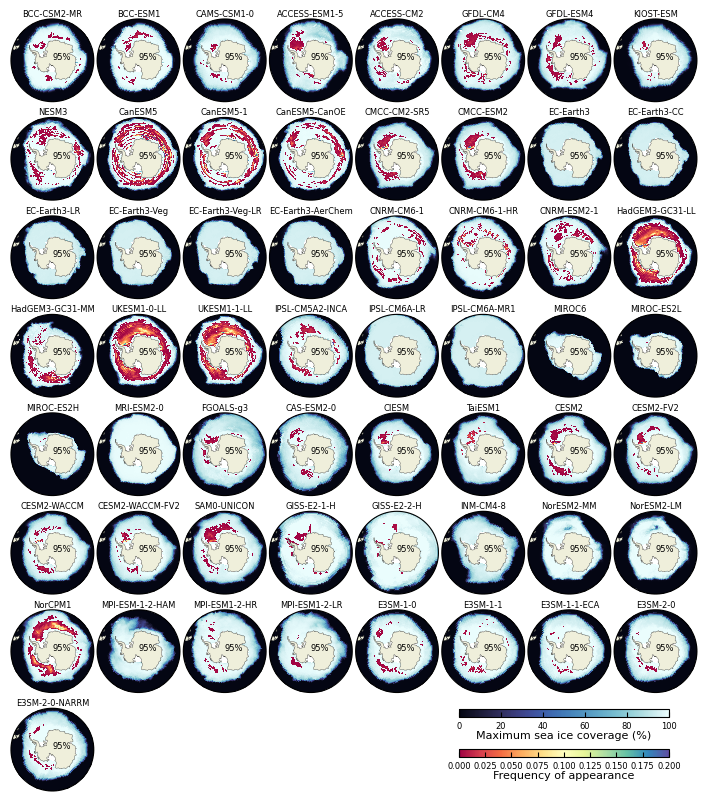

In [10]:
for ice_threshold in ice_thresholds:
    savename = 'Polynya_Multi' + '_' + str(ice_threshold) + '.png'
    if os.path.exists(savename):
        # print('    [o] {} exists.'.format(p))
        continue    
    plot_multi_map(datapd, ice_threshold, title_threshold=True)

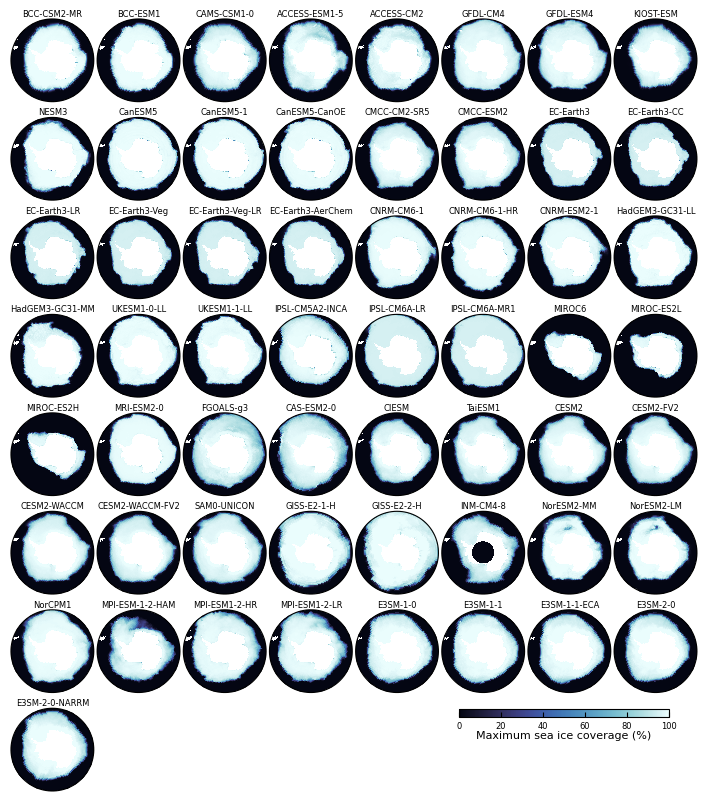

In [26]:
def plot_max_map(datapd, figsize = (7, 8)):
    fig = plt.figure(figsize=figsize)
    n = 1
    for i in range(0, len(datapd)):
        name = datapd.at[i, 'source_id']
        if not ispickleexists(name, 'data_siconc_w_area/'):
            continue
        ds = openpickle(name, 'data_siconc_w_area/')
        ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(
            left=0.01,
            bottom=0.01,
            right=0.99,
            top=0.99,
            wspace=0.04,
            hspace=0.04
        )
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    
        ax.set_title(name, fontsize=6, pad=-0.5)
        pltx = ds.newlon
        plty = ds.newlat
        ice_max = ds.siconc.max('time')
        
        im = ax.pcolormesh(pltx, plty, ice_max, 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=100, 
                           cmap=cmocean.cm.ice)
        
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1       
        
    cbar_ax1 = fig.add_axes([0.65, 0.11, 0.30, 0.01])
    cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
    cbar1.ax.tick_params(labelsize=6,direction='in')

plot_max_map(datapd)

In [94]:
ds = openpickle('FGOALS-g3', 'data_siconc_w_area/')

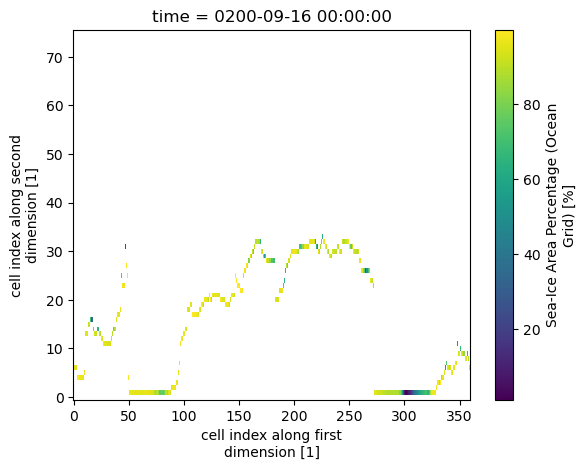

In [99]:
ds.siconc.where(ds.siconc.j == find_first_non_nan_row(ds.siconc)).isel(time=0).plot()

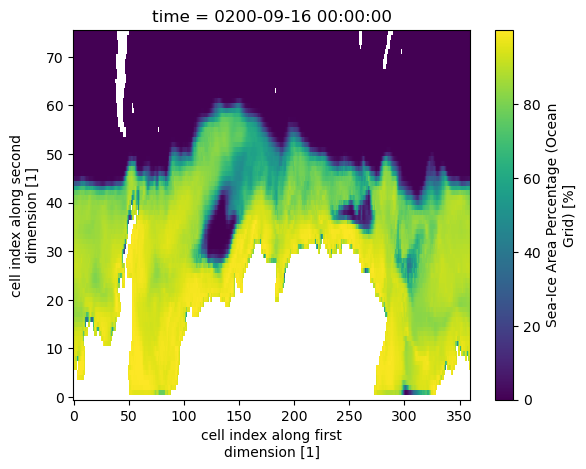

In [91]:
ds.siconc.isel(time = 0).plot()